## Task 3: Feature Engineering & Modelling
<font size="3"> **Background information**
    
<font size="3">The team now has a good understanding of the data and feels confident to use the data to further understand the business problem. The team now needs to brainstorm and build out features to uncover signals in the data that could inform the churn model.

<font size="3">Feature engineering is one of the keys to unlocking predictive insight through mathematical modeling. Based on the data that is available and was cleaned, identify what you think could be drivers of churn for our client and build those features to later use in your model.

<font size="3">First focus on building on top of the feature that your colleague has already investigated: “the difference between off-peak prices in December and January the preceding year”. After this, if you have time, feel free to get creative with making any other features that you feel are worthwhile.

<font size="3">Once you have a set of features, you must train a Random Forest classifier to predict customer churn and evaluate the performance of the model with suitable evaluation metrics. Be rigorous with your approach and give full justification for any decisions made by yourself as the intern data scientist. 

<font size="3">Recall that the hypotheses under consideration is that churn is driven by the customers’ price sensitivities and that it would be possible to predict customers likely to churn using a predictive model.

<font size="3">If you’re eager to go the extra mile for the client, when you have a trained predictive model, remember to investigate the client’s proposed discounting strategy, with the head of the SME division suggesting that offering customers at high propensity to churn a 20% discount might be effective.

<font size="3">Build your models and test them while keeping in mind you would need data to prove/disprove the hypotheses, as well as to test the effect of a 20% discount on customers at high propensity to churn.
    
<font size="3"> **Task**
    
<font size="3">Sub-Task 1

<font size="3">Your colleague has done some work on engineering the features within the cleaned dataset and has calculated a feature which seems to have predictive power. 

<font size="3">This feature is “the difference between off-peak prices in December and January the preceding year”. 

<font size="3">Run the cells in the notebook provided (named feature_engineering.ipynb) to re-create this feature. then try to think of ways to improve the feature’s predictive power and elaborate why you made those choices. 

<font size="3">Sub-Task 2

<font size="3">Now that you have a dataset of cleaned and engineered features, it is time to build a predictive model to see how well these features are able to predict a customer churning. It is your task to train a Random Forest classifier and to evaluate the results in an appropriate manner. We would also like you to document the advantages and disadvantages of using a Random Forest for this use case. 

In [70]:
# load packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Sub-Task 1

<font size="3"> Prepare date

In [71]:
# drop useless columns
train_data = client.copy()
train_data['year_modif_prod'] = train_data['date_modif_prod'].dt.year
train_data['year_renewal'] = train_data['date_renewal'].dt.year
train_data = train_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])
# 
has_gas_encoder = LabelEncoder()
train_data['has_gas'] = has_gas_encoder.fit_transform(train_data['has_gas'])
# add new feature "diff_dec_jan_off_peak_var" and "diff_dec_jan_off_peak_fix". I just calculate the differnece between last price and first price for each customer.
diff_dec_jan_off_peak_var = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(-1) - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(0)
diff_dec_jan_off_peak_var = diff_dec_jan_off_peak_var.reset_index(name='diff_dec_jan_off_peak_var')
diff_dec_jan_off_peak_fix = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(-1) - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(0)
diff_dec_jan_off_peak_fix = diff_dec_jan_off_peak_fix.reset_index(name='diff_dec_jan_off_peak_fix')
train_data = train_data.merge(diff_dec_jan_off_peak_var, on='id', how='left')
train_data = train_data.merge(diff_dec_jan_off_peak_fix, on='id', how='left')
# also add the above differences of other prices
for attr in ['price_peak_var','price_peak_fix','price_mid_peak_var','price_mid_peak_fix']:
    diff_dec_jan_temp = price.sort_values(by=['price_date']).groupby(['id'])[attr].nth(-1) - price.sort_values(by=['price_date']).groupby(['id'])[attr].nth(0)
    diff_dec_jan_temp = diff_dec_jan_temp.reset_index(name=f'diff_dec_jan_{attr}')
    train_data = train_data.merge(diff_dec_jan_temp, on='id', how='left')
# add price changing trends
train_data = train_data.merge(price_stat[['id','diff_Dec_mean_price_off_peak_var','diff_Dec_mean_price_off_peak_fix',
                                          'diff_Dec_mean_price_peak_var','diff_Dec_mean_price_peak_fix',
                                          'diff_Dec_mean_price_mid_peak_var','diff_Dec_mean_price_mid_peak_fix',
                                        ]], on='id', how='left')

#
train_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,year_modif_prod,year_renewal,diff_dec_jan_off_peak_var,diff_dec_jan_off_peak_fix,diff_dec_jan_price_peak_var,diff_dec_jan_price_peak_fix,diff_dec_jan_price_mid_peak_var,diff_dec_jan_price_mid_peak_fix,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,2015,2015,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389,0.021246,3.324664,-0.015266,-22.352010,-0.066530,-14.901340
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,2009,2015,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000,-0.002009,0.133335,-0.007124,0.000000,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,2010,2015,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000,-0.002714,0.059260,-0.000012,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,2010,2015,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000,-0.002624,0.044445,0.000000,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,2010,2015,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166,-0.004268,0.040729,-0.001965,0.024437,0.000854,0.016292


<font size="3"> Create training data and training label. 
    
<font size="3"> Note: for tree-based models
- <font size="3"> there is no need to perform data scaling, unlike other machine learning models.
- <font size="3"> do not apply one-hot encoding to processing categorical variables, just use label-encoding to convert categorical variables to numeric variables.

In [72]:
X = train_data.drop(columns=['id','churn'])
y = train_data['churn']
X.shape, y.shape

((14606, 36), (14606,))

### Sub-Task 2

<font size="3"> According to the task requirement, build a RandomForest model.
    
<font size="3"> As there is no testing set, the "out-of-fold" cross validation strategy is used to evaluate the model's performace. Besides, the training set is a very imbalanced dataset, so I use precision and recall as the metrics, instead of accuracy (results of accuracy are still shown, but not for evaluating the model's performance). As the goal of this task is not finding the optimal parameters, I do not tune the model's parameters.

In [73]:
# 
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
feature_importance_df = pd.DataFrame(data={'feature_name':X.columns, 'feature_importance':[0]*len(X.columns)})
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    feature_importance_df['feature_importance'] = feature_importance_df['feature_importance'] + (rf.feature_importances_)
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
# predicted labels
pred_y = pred_train_labels.argmax(axis=-1)
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.714 Recall 0.053 Accuracy 0.906
Fold 2 Precision 0.885 Recall 0.081 Accuracy 0.910
Fold 3 Precision 0.895 Recall 0.060 Accuracy 0.908
Fold 4 Precision 0.944 Recall 0.060 Accuracy 0.908
Fold 5 Precision 0.850 Recall 0.060 Accuracy 0.908
Total  Precision 0.856 Recall 0.063 Accuracy 0.908


<font size="3"> The below figure displays how important each feature is when growing trees.

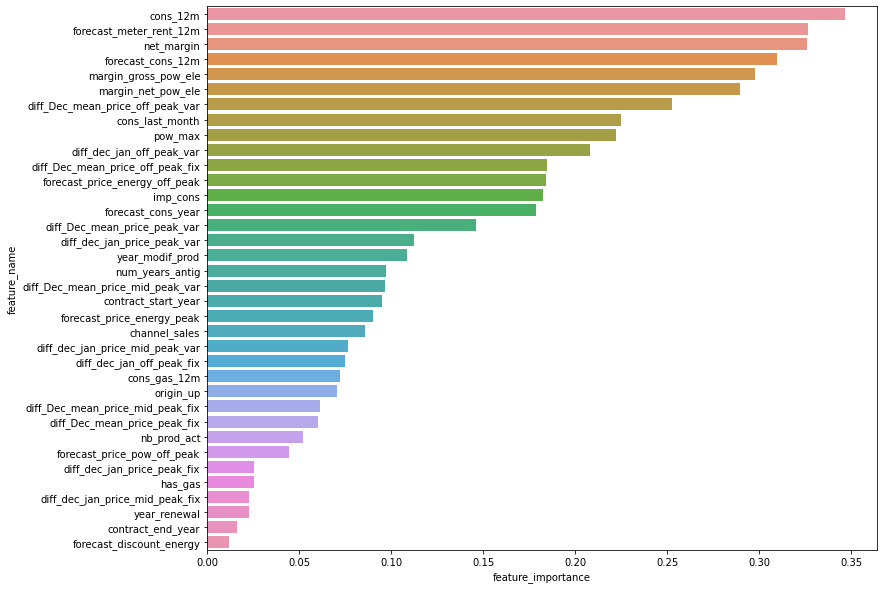

In [74]:
fig = plt.figure(figsize=(12,10))
ax = sns.barplot(data=feature_importance_df.sort_values(by=['feature_importance'], ascending=False), y='feature_name', x='feature_importance')

<font size="3"> The below table shows the main classification metrics.

In [75]:
print(classification_report(y, pred_y))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13187
           1       0.86      0.06      0.12      1419

    accuracy                           0.91     14606
   macro avg       0.88      0.53      0.53     14606
weighted avg       0.90      0.91      0.87     14606



<font size="3"> The below figure shows the confusion matrix.

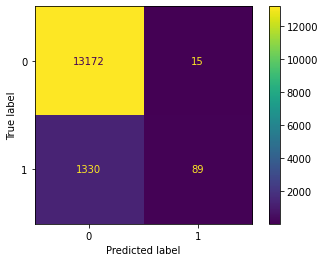

In [76]:
cm = confusion_matrix(y, pred_y, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

<font size="3"> **Based on the results above, we can see the performance is very bad. Although the accuracy is up to 90%, it is misleading and pointless, as we only focus on correctly predicting the positive class rather than the nagetive class. The model can only find out 6% of real positive samples. But luckily, in the predicted positive samples, up to 86% of them are real positive samples.** 

### Bonus task: identify the impact of a 20% discount
<font size="3"> This is a tricky problem.
- <font size="3"> first, intuitively, we have concluded that changes in prices do not have a significant impact on customer churn. So, a discount should be unable to prevent customer churn.
- <font size="3"> second, we cannot really identify whether a discount can prevent customer churn, as we do not exactly know what will happen in the future.

<font size="3"> Therefore, I try to calculate the expected profit based on the probability of customer churn and evaluate the impact of the discount. 

In [77]:
prob_no_discount = pd.DataFrame(data = pred_train_labels, columns=['0', '1'])
prob_no_discount['id'] = train_data['id']
prob_no_discount = prob_no_discount[['id','0','1']]
prob_no_discount

,id,0,1
0,24011ae4ebbe3035111d65fa7c15bc57,0.66,0.34
1,d29c2c54acc38ff3c0614d0a653813dd,0.95,0.05
2,764c75f661154dac3a6c254cd082ea7d,0.89,0.11
3,bba03439a292a1e166f80264c16191cb,0.84,0.16
4,149d57cf92fc41cf94415803a877cb4b,0.99,0.01
...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.90,0.10
14602,d0a6f71671571ed83b2645d23af6de00,0.41,0.59
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.86,0.14
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.93,0.07


<font size="3"> We need to predcit the probability of churn when applying a 20% discount. Note: I still use the data on this year, not the next year.

In [78]:
# drop useless columns
test_data = client.copy()
test_data['year_modif_prod'] = test_data['date_modif_prod'].dt.year
test_data['year_renewal'] = test_data['date_renewal'].dt.year
test_data = test_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])
# 
has_gas_encoder = LabelEncoder()
test_data['has_gas'] = has_gas_encoder.fit_transform(test_data['has_gas'])
# apply a 20% discount
diff_dec_jan_off_peak_var = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(-1)*0.8 - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(0)*0.8
diff_dec_jan_off_peak_var = diff_dec_jan_off_peak_var.reset_index(name='diff_dec_jan_off_peak_var')
diff_dec_jan_off_peak_fix = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(-1)*0.8 - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(0)*0.8
diff_dec_jan_off_peak_fix = diff_dec_jan_off_peak_fix.reset_index(name='diff_dec_jan_off_peak_fix')
test_data = test_data.merge(diff_dec_jan_off_peak_var, on='id', how='left')
test_data = test_data.merge(diff_dec_jan_off_peak_fix, on='id', how='left')
# also add the above differences of other prices
for attr in ['price_peak_var','price_peak_fix','price_mid_peak_var','price_mid_peak_fix']:
    diff_dec_jan_temp = price.sort_values(by=['price_date']).groupby(['id'])[attr].nth(-1)*0.8 - price.sort_values(by=['price_date']).groupby(['id'])[attr].nth(0)*0.8
    diff_dec_jan_temp = diff_dec_jan_temp.reset_index(name=f'diff_dec_jan_{attr}')
    test_data = test_data.merge(diff_dec_jan_temp, on='id', how='left')
# add price changing trends
price_attr = ['price_off_peak_var','price_peak_var','price_mid_peak_var','price_off_peak_fix','price_peak_fix','price_mid_peak_fix']
price_stat_test = price.drop(columns=['price_date']).groupby(['id']).agg({'price_off_peak_var': ['mean'], 'price_peak_var': ['mean'], 'price_mid_peak_var': ['mean'],
                                                      'price_off_peak_fix': ['mean'], 'price_peak_fix': ['mean'], 'price_mid_peak_fix': ['mean'],})
# flatten the column names
price_stat_test.columns = ['_'.join(x) for x in zip(price_stat_test.columns.get_level_values(0), price_stat_test.columns.get_level_values(1))]
price_stat_test = price_stat_test.reset_index()
# add diff
for attr in price_attr:
    price_stat_test[f'diff_Dec_mean_{attr}'] = price[price['id'].isin(price_stat_test['id'])].groupby(['id'])[attr].nth(-1).values*0.8 - price_stat_test[f'{attr}_mean']*0.8
#
test_data = test_data.merge(price_stat_test[['id','diff_Dec_mean_price_off_peak_var','diff_Dec_mean_price_off_peak_fix',
                                          'diff_Dec_mean_price_peak_var','diff_Dec_mean_price_peak_fix',
                                          'diff_Dec_mean_price_mid_peak_var','diff_Dec_mean_price_mid_peak_fix',
                                        ]], on='id', how='left')

#
test_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,year_modif_prod,year_renewal,diff_dec_jan_off_peak_var,diff_dec_jan_off_peak_fix,diff_dec_jan_price_peak_var,diff_dec_jan_price_peak_fix,diff_dec_jan_price_mid_peak_var,diff_dec_jan_price_mid_peak_fix,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,2015,2015,0.016046,2.960768,-0.014330,-19.471665,-0.057229,-12.981111,0.016997,2.659732,-0.012213,-17.881608,-0.053224,-11.921072
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,2009,2015,-0.003014,0.142223,0.000000,0.000000,0.000000,0.000000,-0.001607,0.106668,-0.005699,0.000000,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,2010,2015,-0.003736,0.142223,0.000422,0.000000,0.000000,0.000000,-0.002171,0.047408,-0.000010,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,2010,2015,-0.003638,0.142223,0.000000,0.000000,0.000000,0.000000,-0.002099,0.035556,0.000000,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,2010,2015,-0.004954,0.130332,-0.001842,0.078199,0.002790,0.052133,-0.003415,0.032583,-0.001572,0.019550,0.000683,0.013033


In [79]:
#
testing_set = test_data.drop(columns=['id','churn'])
testing_set.shape

(14606, 36)

In [80]:
# 
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
pred_test_labels = np.zeros(shape=(testing_set.shape[0], 2))
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    pred_test_labels += rf.predict_proba(testing_set)/5
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
# 
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.714 Recall 0.053 Accuracy 0.906
Fold 2 Precision 0.885 Recall 0.081 Accuracy 0.910
Fold 3 Precision 0.895 Recall 0.060 Accuracy 0.908
Fold 4 Precision 0.944 Recall 0.060 Accuracy 0.908
Fold 5 Precision 0.850 Recall 0.060 Accuracy 0.908
Total  Precision 0.856 Recall 0.063 Accuracy 0.908


<font size="3"> Now, combine all results into a single dataset.

In [81]:
#
prob_discount = pd.DataFrame(data=pred_test_labels, columns=['0_dis','1_dis'])
customer_prob = prob_no_discount.join(prob_discount)
customer_prob.head()

,id,0,1,0_dis,1_dis
0,24011ae4ebbe3035111d65fa7c15bc57,0.66,0.34,0.422,0.578
1,d29c2c54acc38ff3c0614d0a653813dd,0.95,0.05,0.948,0.052
2,764c75f661154dac3a6c254cd082ea7d,0.89,0.11,0.888,0.112
3,bba03439a292a1e166f80264c16191cb,0.84,0.16,0.936,0.064
4,149d57cf92fc41cf94415803a877cb4b,0.99,0.01,0.970,0.030


<font size="3"> Then, let's calculate the expected profit from customers.

In [82]:
# calculate expected profit of a single customer with discounted prices and without discounted prices
def expect_from_a_customer(customer_id):
    # expected values without discount
    average_yearly_price_var = price_stat[price_stat['id']==customer_id]['price_off_peak_var_mean'].values[0]
    total_yearly_usage_var = client[client['id']==customer_id]['cons_12m'].values[0]
    average_yearly_price_fix = price_stat[price_stat['id']==customer_id]['price_off_peak_fix_mean'].values[0]
    total_yearly_usage_fix = client[client['id']==customer_id]['cons_gas_12m'].values[0]
    total_profit = average_yearly_price_var*total_yearly_usage_var + average_yearly_price_fix*total_yearly_usage_fix
    # 
    prob_stay = customer_prob[customer_prob['id']==customer_id]['0'].values[0]
    expected_profit = prob_stay*total_profit
    # expected values with discount
    total_profit_dis = total_profit*0.8
    # 
    prob_stay_dis = customer_prob[customer_prob['id']==customer_id]['0_dis'].values[0]
    expected_profit_dis = prob_stay_dis*total_profit_dis
    return expected_profit, expected_profit_dis

In [83]:
# Calculate expected profit from each customer
expected_no_dis, expected_dis = [],[]
for cus_id in customer_prob['id']:
    temp = expect_from_a_customer(customer_id=cus_id)
    expected_no_dis.append(temp[0])
    expected_dis.append(temp[1])
#
customer_prob['expected_no_dis'] = expected_no_dis
customer_prob['expected_dis'] = expected_dis
customer_prob['diff_discount'] = customer_prob['expected_dis'] - customer_prob['expected_no_dis']
customer_prob

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
0,24011ae4ebbe3035111d65fa7c15bc57,0.66,0.34,0.422,0.578,1.484745e+06,7.594696e+05,-725275.463026
1,d29c2c54acc38ff3c0614d0a653813dd,0.95,0.05,0.948,0.052,6.623187e+02,5.287395e+02,-133.579219
2,764c75f661154dac3a6c254cd082ea7d,0.89,0.11,0.888,0.112,8.255493e+01,6.589553e+01,-16.659399
3,bba03439a292a1e166f80264c16191cb,0.84,0.16,0.936,0.064,2.011941e+02,1.793502e+02,-21.843930
4,149d57cf92fc41cf94415803a877cb4b,0.99,0.01,0.970,0.030,5.439767e+02,4.263898e+02,-117.586885
...,...,...,...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.90,0.10,0.936,0.064,1.918601e+06,1.596276e+06,-322325.008098
14602,d0a6f71671571ed83b2645d23af6de00,0.41,0.59,0.386,0.614,3.162780e+02,2.382113e+02,-78.066670
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.86,0.14,0.596,0.404,1.971808e+02,1.093207e+02,-87.860111
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.93,0.07,0.932,0.068,1.822685e+01,1.461284e+01,-3.614013


<font size="3"> Expected profit from only 349 customers (2%) rise after being offered discounted prices.

In [84]:
customer_prob[customer_prob['diff_discount']>0]

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
128,3c4ee938001975a4d07cf27a54de433c,0.67,0.33,0.888,0.112,3254.731758,3450.987225,196.255467
139,cf8c5db0c02e3f92592daccba41c918c,0.60,0.40,0.782,0.218,501505.138799,522902.691387,21397.552589
217,b1e773762052b38569b1e68aaa10576e,0.39,0.61,0.576,0.424,2692.006048,3180.708684,488.702636
230,9ca6298400dbc960a48a46aa6abd3db7,0.25,0.75,0.354,0.646,2565.754701,2906.486925,340.732224
346,395a6f41bbd1a0f23a64f00645264e78,0.64,0.36,0.818,0.182,4439.209887,4539.092109,99.882222
...,...,...,...,...,...,...,...,...
14384,87ec37604794b702c77225967c20f476,0.64,0.36,0.864,0.136,215.637276,232.888258,17.250982
14536,acfb0c97e40a86087f185d4846217966,0.68,0.32,0.862,0.138,213950.664602,216971.144572,3020.479971
14537,d77e823d24aa59beda5baa6bca37c903,0.63,0.37,0.846,0.154,264.275878,283.907801,19.631922
14561,37f06f14bb662b84f4f464322dce72db,0.68,0.32,0.878,0.122,1118.446236,1155.289171,36.842935


In [85]:
# 2% of all cutomers
customer_prob[customer_prob['diff_discount']>0].shape[0]/len(customer_prob)

0.023894290017800905

<font size="3"> Among the 104 predcited churning customers, after being offered discounted prices,
    
- <font size="3"> the expected profit from 61 customers increase and total expected profit increase by 2250001. 
    
- <font size="3"> the expected profit from 43 customers decrease and total expected profit decrease by 1138753.

<font size="3"> So, it is expected that offering a discount to the predcited churning customers can bring extra profit of 1111248.

In [86]:
# number of churning customers
customer_prob[(customer_prob['1']>0.5)].shape[0]

104

In [87]:
# number of customers whose expected profit increase
customer_prob[(customer_prob['diff_discount']>0)&(customer_prob['1']>0.5)].shape[0]

61

In [88]:
# number of customers whose expected profit decreas
customer_prob[(customer_prob['diff_discount']<=0)&(customer_prob['1']>0.5)].shape[0]

43

In [89]:
# total extra profit from customers whose expected profit increase
customer_prob[(customer_prob['diff_discount']>0)&(customer_prob['1']>0.5)]['diff_discount'].sum()

2250001.9519792725

In [90]:
# total extra profit from customers whose expected profit decrease
customer_prob[(customer_prob['diff_discount']<=0)&(customer_prob['1']>0.5)]['diff_discount'].sum()

-1138753.308247779

In [91]:
# total extra profit from predicted churning customers
customer_prob[customer_prob['1']>0.5]['diff_discount'].sum()

1111248.6437314935

<font size="3"> **Based on the results above, it seems offering a discount to the predicted churning customers can increase the expected profit from these customers.**